In [1]:
# Libraries

# Python

from random import shuffle
import pandas as pd
import pandas_profiling
import numpy as np
import sys
import json

# Machine Learning

import tensorflow as tf
from tensorflow import keras
from keras import initializers
from keras.layers import Dense
from keras.models import Sequential
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Data / Plotting

import matplotlib.pyplot as plt
import pymatgen as pymat
import mendeleev as mendel

%matplotlib inline

Using TensorFlow backend.


In [57]:
# Get all the elements 
elements_list = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg',
            'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr',
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br',
            'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag',
            'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'Hf', 'Ta', 'W',
            'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'La', 'Ce', 'Pr',
            'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
            'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu']

# Create element dictionary
element_property = {}

for item in elements_list:
    element_property[item] = {}
    element_property[item]["youngs_modulus"]= pymat.Element(item).youngs_modulus
    element_property[item]["lattice_constant"] = mendel.element(item).lattice_constant
    element_property[item]["melting_point"] = mendel.element(item).melting_point
    element_property[item]["specific_heat"]= mendel.element(item).specific_heat
    element_property[item]["atomic_mass"] = pymat.Element(item).atomic_mass
    element_property[item]["CTE"] = pymat.Element(item).coefficient_of_linear_thermal_expansion
    element_property[item]["electrical_resistivity"] = pymat.Element(item).electrical_resistivity
    element_property[item]["atomic_radius"] = pymat.Element(item).atomic_radius
    element_property[item]["density_of_solid"] = pymat.Element(item).density_of_solid
    element_property[item]["poissons_ratio"] = pymat.Element(item).poissons_ratio
    element_property[item]["electronegativity"] = mendel.element(item).en_pauling

data_labels = ['element', 'youngs_modulus', 'lattice_constant', 'melting_point', 'specific_heat', 'atomic_mass', 'CTE', 'electrical_resistivity', 
               'atomic_radius', 'density_of_solid', 'poissons_ratio', 'electronegatvity']
print(len(data_labels))

12


In [24]:
# Now, we can create a dataframe of all the elemental data
edf = pd.DataFrame.from_dict(element_property, orient = 'index')
#edf = edf.fillna(0)

In [79]:
# Load in our hardness and yield data
raw_data = np.loadtxt(open("clean_data_with_elements.csv", "r"), delimiter = ',', dtype = str, skiprows = 0)

# Get the labels
labels = raw_data[0]

df = pd.DataFrame(raw_data[1:], columns = labels)

# Drop the 'other' column because... it's pretty useless information for us
df = df.drop('Other', axis = 1)

# We want to convert some of these columns to floating points
df.iloc[:,1:] = df.iloc[:,1:].copy().apply(pd.to_numeric)

In [80]:
# Now, we should clean up this data

# We're also going to check for any columns that are all zero. If this is the case, then the standard deviation
# will be zero, so we would be dividing by zero!

df.loc[:, (df == 0).all(axis=0)].head()

# Drop these elments because they do not appear in the materials at all...
df = df.drop(['As', 'Sn', 'Ta'], axis = 1)

In [81]:
# The data looks like this now
df.head()

,internal_id,avg_hardness,avg_yield,Al,B,Bi,C,Ca,Ce,Co,...,P,Pb,S,Se,Si,Ti,V,W,Zn,Zr
0,MINFM3654700,95,168,95.8,0,0,0,0,0,0,...,0,0,0,0,0.4,0.15,0,0,0.25,0
1,MINFM3654300,30,55,95.8,0,0,0,0,0,0,...,0,0,0,0,0.4,0.15,0,0,0.25,0
2,MINFM3654600,95,168,95.8,0,0,0,0,0,0,...,0,0,0,0,0.4,0.15,0,0,0.25,0
3,MINFM3654500,65,127.5,95.8,0,0,0,0,0,0,...,0,0,0,0,0.4,0.15,0,0,0.25,0
4,MINFM3654400,65,122.5,95.8,0,0,0,0,0,0,...,0,0,0,0,0.4,0.15,0,0,0.25,0


## Weighted Properties

In [82]:
# We are going to remove all the elements that are not present in any material from the dictionary

# First, make a list of the elements present
elems_present = df.iloc[:,3:].columns

# Create a function for "soft" removing a key
def removekey(d, key):
    dcopy = dict(d)
    del dcopy[key]
    return dcopy

# Loop through the elements (keys) in the dictionary
for key in element_property:
    # If said element is not in the list of elems_present...
    if key not in elems_present: 
        # Then, remove that key
        element_property = removekey(element_property,key)
        
print(len(element_property.keys()))
print(len(elems_present))

26
26


Now, we are going to fill the dictionary NA values with 0 values. This should not greatly impact the properties of the materials because the properties are not averaged.They are taken as element_composition * element_property.
Thus, if an NA is present, then it will treat that element as if it had 0 % composition.This should not be significant since that element was not contributing to that property anyway.

In [83]:
# Replace NA's with 0
element_property = {k: {k2: 0 if v2 == None else v2 for k2, v2 in v.items()} \
                    for k, v in element_property.items()}

In [84]:
# Now, we are going to get the "weighted" properties of the elements present

# Get only the elemental compositions and make sure they are numerical values
elem_df = df.iloc[:,3:].copy().apply(pd.to_numeric)

# Create a dataframe to which we will add the properties
final_data = df.copy()

elem_df.head()

,Al,B,Bi,C,Ca,Ce,Co,Cr,Cu,Fe,...,P,Pb,S,Se,Si,Ti,V,W,Zn,Zr
0,95.8,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.15,0.7,...,0.0,0.0,0.0,0.0,0.4,0.15,0.0,0.0,0.25,0.0
1,95.8,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.15,0.7,...,0.0,0.0,0.0,0.0,0.4,0.15,0.0,0.0,0.25,0.0
2,95.8,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.15,0.7,...,0.0,0.0,0.0,0.0,0.4,0.15,0.0,0.0,0.25,0.0
3,95.8,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.15,0.7,...,0.0,0.0,0.0,0.0,0.4,0.15,0.0,0.0,0.25,0.0
4,95.8,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.15,0.7,...,0.0,0.0,0.0,0.0,0.4,0.15,0.0,0.0,0.25,0.0


Here, we create the function that will add the "weighted" properties to the final dataframe. As in, the percent composition of element A will be multiplied by whatever property of element A (divided by 100). 
Then, all the values for each element will be added to come up with a "weighted" property average unique to the material.

In [85]:
def weighted_properties(x): # Enter a property
    # Create a copy of the elemental dataframe
    mod_temp = elem_df.copy()
    
    # For each item in the elements... 
    for item in mod_temp.columns.tolist():
        # Add to the temporary df the elemental composition mod_temp[item] multiplied by whatever property we are referencing
        # Then, divide by 100 since composition is in percent
        mod_temp[item] *= element_property[item][x]/100
    # Add the individual values to get the "weighted" average, and add this to the dataframe
    final_data[x] = mod_temp.sum(axis = 1, skipna = True)

In [86]:
# For a few of the properties, we will just set the total property to that of the majority element
def max_properties(x): # Enter a property
    # Create a copy of the elemental dataframe
    mod_temp = elem_df.copy()
    
    # Create a list to which we will add the properties
    list_properties = []
    
    # For each element (that is the maximum component) 
    elem = mod_temp.idxmax(axis = 1).tolist()
    
    for item in elem: # For each element in the list...
        # Add the properties to the list
        list_properties.append(element_property[item][x])
    final_data[x] = list_properties

In [87]:
# Now, we'll apply our functions to all our properties
max_properties('youngs_modulus')
weighted_properties('lattice_constant')
max_properties('melting_point')
max_properties('specific_heat')
weighted_properties('atomic_mass')
max_properties('CTE')
max_properties('electrical_resistivity')
weighted_properties('atomic_radius')
max_properties('density_of_solid')
max_properties('poissons_ratio')
weighted_properties('electronegativity')

In [88]:
# Here, we take the difference in the maximum atomic radius present and the minimum atomic radius present for each material
binary_temp = elem_df.copy()
binary_temp.where(binary_temp == 0, 1, inplace = True)

mod_binary_temp = binary_temp.copy()
for item in mod_binary_temp.columns.tolist():
    mod_binary_temp[item] *= element_property[item]["atomic_radius"]
final_data["max_min_radius"] =  mod_binary_temp.max(axis = 1) - mod_binary_temp[mod_binary_temp > .01].min(axis=1)

In [89]:
# Rename
df = final_data
df.head()

,internal_id,avg_hardness,avg_yield,Al,B,Bi,C,Ca,Ce,Co,...,melting_point,specific_heat,atomic_mass,CTE,electrical_resistivity,atomic_radius,density_of_solid,poissons_ratio,electronegativity,max_min_radius
0,MINFM3654700,95,168,95.8,0,0,0,0,0,0,...,933.5,0.9,26.979858,0.000023,2.700000e-08,1.23386,2700.0,0.35,1.585544,0.4
1,MINFM3654300,30,55,95.8,0,0,0,0,0,0,...,933.5,0.9,26.979858,0.000023,2.700000e-08,1.23386,2700.0,0.35,1.585544,0.4
2,MINFM3654600,95,168,95.8,0,0,0,0,0,0,...,933.5,0.9,26.979858,0.000023,2.700000e-08,1.23386,2700.0,0.35,1.585544,0.4
3,MINFM3654500,65,127.5,95.8,0,0,0,0,0,0,...,933.5,0.9,26.979858,0.000023,2.700000e-08,1.23386,2700.0,0.35,1.585544,0.4
4,MINFM3654400,65,122.5,95.8,0,0,0,0,0,0,...,933.5,0.9,26.979858,0.000023,2.700000e-08,1.23386,2700.0,0.35,1.585544,0.4


## Data Cleaning

In [90]:
# We're going to check for any NA's since those could give us problems later
print(df.isnull().values.any())

# Find and drop those NaN
to_drop = list(df[df.isna().any(axis=1)].index)
df = df.drop(to_drop, axis = 0)

# Now, it should have none
print(df.isnull().values.any())

True
False


In [15]:
# Here (if this is the first time running), we save the dataframe

#pd.DataFrame(df).to_csv('basic_df.csv')

In [16]:
# And here, we may load it in
'''
raw_df = np.loadtxt(open("basic_df.csv", "r"), delimiter = ',', dtype = str, skiprows = 0)

# Get the labels
df_labels = raw_df[0,1:]

# Make the dataframe
df = pd.DataFrame(raw_df[1:,1:], columns = df_labels)

# Convert to numeric values
df.iloc[:,1:] = df.iloc[:,1:].apply(pd.to_numeric)
df.head()
'''

'\nraw_df = np.loadtxt(open("basic_df.csv", "r"), delimiter = \',\', dtype = str, skiprows = 0)\n\n# Get the labels\ndf_labels = raw_df[0,1:]\n\n# Make the dataframe\ndf = pd.DataFrame(raw_df[1:,1:], columns = df_labels)\n\n# Convert to numeric values\ndf.iloc[:,1:] = df.iloc[:,1:].apply(pd.to_numeric)\ndf.head()\n'

### Remove Duplicates

Now, we want to get rid of "duplicate" materials. It could prove difficult if there are many materials with exactly the same composition but different hardness and yield values. It means that they are the same material, but they were processed differently. Thus, we are going to remove all the duplicates, leaving only one material with that composition. This materials will be the one with the lowest hardness value because it was assumedly processed the least.

In [91]:
duplicate_df = df[df.iloc[:, 3:].duplicated()]

# That's... a lot of duplicates
print(len(duplicate_df))

# We're going to attempt to keep ONE of the values from all the duplicates (see next cell)

1505


In [92]:
# DUPLICATING CRITERIA, WE KEEP THE ONE IN THE MEDIAN

duplicated_indexes = df[df.duplicated(subset = df.columns.tolist()[3:], keep=False)].index.tolist()

another_df = df[df.duplicated(subset = df.columns.tolist()[3:], keep=False)]

list_duplicates = [np.array(another_df.iloc[x]) for x in range(len(another_df.index))]

grouped_duplicates = []

for outer_index in range(len(list_duplicates)):
    for inner_index in range(outer_index+1,len(list_duplicates)):
        if np.array_equal(list_duplicates[outer_index][3:], list_duplicates[inner_index][3:]):
            grouped_duplicates.append([duplicated_indexes[outer_index], duplicated_indexes[inner_index]])

# -------------------------------------------------------
# CODE TO MERGE LISTS OF LISTS WITH REPEATED ELEMENTS TO INDIVIDUAL LISTS OF LISTS. Taken from: https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
resultlist = [grouped_duplicates[0]]

for l in grouped_duplicates[1:]: #Loop through lists starting at list 1
    listset = set(l) #Turn you list into a set
    merged = False
    for index in range(len(resultlist)): #Use indexes of the list for speed.
        rset = set(resultlist[index]) #Get list from you resultset as a set
        if len(listset & rset) != 0: #If listset and rset have a common value then the len will be greater than 1
            resultlist[index] = list(listset | rset) #Update the resultlist with the updated union of listset and rset
            merged = True #Turn trigger to True
            break #Because you found a match there is no need to continue the for loop.
    if not merged: #If there was no match then add the list to the resultset, so it doesnt get left out.
        resultlist.append(l)

# -------------------------------------------------------
# Grouped_set is a list of lists. Each list contains every index of an 'identical' material. For example, if the first five
# materials have exactly the same composition, then the first entry in resultlist will be [0,1,2,3,4].

# IMPORTANT! I am going to assume that, out of all the duplicates, the 'pure' material is the one with the lowest hardness value.
# This is a reasonable assumption since most processing techniques exist to harden/toughen a material or to soften one that's
# already been processed!
for grouped_set in resultlist: # For each list of index values    
    # Create an empty dataframe
    hard_df = pd.DataFrame(columns = ['internal_id','min_hardness', 'yield'])
    for i in range(0,len(grouped_set)): # Fill said dataframe with the hardness and yield values 
                                        # of all identical materials of a certain composition
        hard_df.loc[i] = [df.at[grouped_set[i], "internal_id"], df.at[grouped_set[i],"avg_hardness"], df.at[grouped_set[i],"avg_yield"]]
    
    # Now, we will sort the dataframe by minimum value first, create a list of those values, and take only the first entry
    min_hardness = (hard_df.sort_values(by = 'min_hardness').values)[0]
    
    # Set the internal id in our original dataframe to the one that is associated with the minimum hardness values
    df.at[grouped_set[0], "internal_id"] = min_hardness[0]
    # Set the avg_hardness in our original dataframe for that index to the minimum hardness value (all else stays the same)
    df.at[grouped_set[0],"avg_hardness"] = min_hardness[1]
    # Set the avg_yield in our original dataframe to the associated yield value (for that index)
    df.at[grouped_set[0],"avg_yield"] = min_hardness[2]
    
    # Drop everything else
    df = df.drop(grouped_set[1:], axis = 0)
# This is the length of our dataframe now
print(len(df))
# This is what our dataframe looks like now
df.head()

881


,internal_id,avg_hardness,avg_yield,Al,B,Bi,C,Ca,Ce,Co,...,melting_point,specific_heat,atomic_mass,CTE,electrical_resistivity,atomic_radius,density_of_solid,poissons_ratio,electronegativity,max_min_radius
0,MINFM3654300,30,55,95.8,0,0,0,0,0,0,...,933.5,0.900,26.979858,0.000023,2.700000e-08,1.23386,2700.0,0.35,1.585544,0.40
5,COME029,80,280,0,0,0,0,0,0,0,...,1726.0,0.443,57.326168,0.000013,7.200000e-08,1.37400,8908.0,0.31,1.871600,0.05
6,COME051,333.5,827,0.5,0,0,0,0,0,0,...,1726.0,0.443,59.128091,0.000013,7.200000e-08,1.36835,8908.0,0.31,1.823810,0.20
7,MITF730,95,250,91.3,0,0.2,0,0,0,0,...,933.5,0.900,29.343290,0.000023,2.700000e-08,1.23380,2700.0,0.35,1.597690,0.70
16,MITF3230,58,95,94.4,0,0,0,0,0,0,...,933.5,0.900,26.940651,0.000023,2.700000e-08,1.24520,2700.0,0.35,1.584840,0.40


### Dropping Materials with Compositions < 90%

For some materials, only the trace elements were listed. Thus, there is no majority material. Obviously, this is an issue, and we should get rid of those materials.

In [93]:
# Make numeric (again, just in case)
df.iloc[:,1:] = df.iloc[:,1:].copy().apply(pd.to_numeric)

# Make a subset of dataframes with only elemental composition
elem_comps = df.iloc[:, 3:-12].copy()

# Add a column that has the sum of the elemental compositions
df['sum'] = elem_comps.sum(axis = 1) 

# Drop materials with a total elemental composition < 90%
df = df[df['sum'] >= 90]

# Now drop the 'sum' column
df = df.drop('sum', axis = 1)

print(len(df))
df.head()

678


,internal_id,avg_hardness,avg_yield,Al,B,Bi,C,Ca,Ce,Co,...,melting_point,specific_heat,atomic_mass,CTE,electrical_resistivity,atomic_radius,density_of_solid,poissons_ratio,electronegativity,max_min_radius
0,MINFM3654300,30.0,55.0,95.8,0.0,0.0,0.0,0.0,0.0,0.0,...,933.5,0.900,26.979858,0.000023,2.700000e-08,1.23386,2700.0,0.35,1.585544,0.40
5,COME029,80.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1726.0,0.443,57.326168,0.000013,7.200000e-08,1.37400,8908.0,0.31,1.871600,0.05
6,COME051,333.5,827.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,1726.0,0.443,59.128091,0.000013,7.200000e-08,1.36835,8908.0,0.31,1.823810,0.20
7,MITF730,95.0,250.0,91.3,0.0,0.2,0.0,0.0,0.0,0.0,...,933.5,0.900,29.343290,0.000023,2.700000e-08,1.23380,2700.0,0.35,1.597690,0.70
16,MITF3230,58.0,95.0,94.4,0.0,0.0,0.0,0.0,0.0,0.0,...,933.5,0.900,26.940651,0.000023,2.700000e-08,1.24520,2700.0,0.35,1.584840,0.40


### Infrequent Elements
Now, we also need to check for elements that appear 'infrequently.' If there are few enough materials containing a certain element that all of the materials with that element are sorted (randomly) into the testing set, that means that our neural net won't know how to predict the hardness (having never encountered that element in the training set)! 

Here, we (somewhat arbitrarily) choose 20 as our minimum value.
We also (of course), get rid of any elements that don't appear at all!

In [94]:
# This will create a list of how many times each column is a nonzero number
num_zeros = list(df.astype(bool).sum(axis=0))
print(num_zeros)  # The first three will be as long as the dataframe
print(df.columns) # Print the columns so that we can see which columns have low non-zero entries

# We make an empty list to "which we will add all of the 'infrequent' elements
low_entries = []

for i,j in enumerate(num_zeros):
    if j < 20:
        low_entries.append(True)
    else:
        low_entries.append(False)

# Create a list of the elements that need to be dropped       
to_drop = []
for i,j in enumerate(low_entries):
    if j == True:
        to_drop.append(df.columns.to_list()[i])
print(to_drop)

[678, 678, 678, 35, 22, 1, 367, 1, 5, 0, 483, 44, 674, 16, 412, 262, 51, 21, 267, 7, 2, 27, 2, 290, 28, 54, 14, 16, 3, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 605]
Index(['internal_id', 'avg_hardness', 'avg_yield', 'Al', 'B', 'Bi', 'C', 'Ca',
       'Ce', 'Co', 'Cr', 'Cu', 'Fe', 'Mg', 'Mn', 'Mo', 'N', 'Nb', 'Ni', 'P',
       'Pb', 'S', 'Se', 'Si', 'Ti', 'V', 'W', 'Zn', 'Zr', 'youngs_modulus',
       'lattice_constant', 'melting_point', 'specific_heat', 'atomic_mass',
       'CTE', 'electrical_resistivity', 'atomic_radius', 'density_of_solid',
       'poissons_ratio', 'electronegativity', 'max_min_radius'],
      dtype='object')
['Bi', 'Ca', 'Ce', 'Co', 'Mg', 'P', 'Pb', 'Se', 'W', 'Zn', 'Zr']


In [95]:
# First, I'm going to drop any rows (AKA, materials) that had any of the 'infrequent' elements

for element in to_drop:
    # Get the index of any materials where the value is not equal to zero for the elements in to_drop
    indexNames = df[df[element] != 0].index
    
    # Delete these row indexes from dataframe
    df.drop(indexNames, inplace=True)

# Now, I'm going to drop any columns (elements) that were 'infrequent' and convert everything to numerical values
df = df.drop(to_drop, axis = 1)

# We should also drop any rows of all zeros (if those are there, for whatever reason)
df = df[(df.iloc[:,3:].T != 0).any()]

# This is the number of nonzero values in each column (once again)
num_nonzero = list(df.astype(bool).sum(axis=0))
print(num_nonzero)

# How long our dataframe is now
print("The length of the DataFrame now is")
print(len(df))

[630, 630, 630, 16, 22, 351, 449, 23, 629, 379, 250, 45, 17, 250, 21, 263, 19, 47, 630, 630, 630, 630, 630, 630, 630, 630, 630, 630, 630, 557]
The length of the DataFrame now is
630


In [108]:
# We should also drop any columns that are all zero

# Make all the data numeric first
df.iloc[:,1:] = df.iloc[:,1:].copy().apply(pd.to_numeric)

# We're also going to check for any columns that are all zero. If this is the case, then the standard deviation
# will be zero, so we would be dividing by zero!

df.loc[:, (df == 0).all(axis=0)].head()

# Drop these elments because they do not appear in the materials at all...

""
70
72
73
77
80


Out of curiosity, I would like to see what the majority component is for the materials. If the vast majority of the materials are mostly iron, and only a handful are majority copper, then the network will most likely not perfom well on the copper materials.

In [109]:
major_df = df.iloc[:,3:-12].copy()
major_df = pd.DataFrame(major_df.idxmax(axis = 1))
major_df[0].value_counts()

Fe    626
Name: 0, dtype: int64

In [98]:
# We should drop those few occurences of Nickel...
this = major_df.loc[major_df[0] == "Ni"].index
df = df.drop(this, axis = 0)

print(len(df))

626


In [49]:
# In case we want to save the clean dataframe
#pd.DataFrame(df).to_csv('df_no_duplicates_clean_2.0.csv')

## Pearson Correlation Coefficients

Now, we're going to create a Pearson correlation chart (heatmap). 
All values will be between -1 (a negative line implying a 1:1 relationship) and +1 (positive line with 1:1 relationship). The center diagonal will have all +1 correlations since every variable is correlated (positively) with itself. The closer the absolute value is to 1, the more correlated the variables are.
This should give us an idea of how important each descriptor is to predicting the output.

In [114]:
# Create an data frame that displays all the correlation coefficients between the inputs
# Get only the numeric data
data = df.iloc[:,1:].copy()
# Get the labels
data_labels = data.columns
# Find the pearson correlation coefficients between each variable
pcorr = data.corr(method = 'pearson')
# Get an array
p = pcorr.values

pcorr.head()

,avg_hardness,Al,B,C,Cr,Cu,Fe,Mn,Mo,N,...,melting_point,specific_heat,atomic_mass,CTE,electrical_resistivity,atomic_radius,density_of_solid,poissons_ratio,electronegativity,max_min_radius
avg_hardness,1.000000,0.059285,0.068926,0.072071,0.043012,0.114258,-0.086012,0.039332,0.128070,0.167064,...,NaN,-6.573114e-16,-0.037906,-8.829115e-16,1.937873e-16,-0.065320,NaN,8.685162e-16,-0.044269,0.198794
Al,0.059285,1.000000,-0.013329,-0.021699,0.072006,-0.021063,-0.092329,-0.047647,0.039386,-0.031072,...,NaN,-2.118396e-16,-0.068628,-3.006157e-16,-1.521177e-16,-0.060949,NaN,-5.184819e-16,-0.052137,-0.013671
B,0.068926,-0.013329,1.000000,-0.077776,0.122634,-0.015296,-0.158441,-0.042310,-0.041265,-0.022595,...,NaN,6.730746e-16,-0.188041,3.429756e-16,-4.499664e-16,-0.173432,NaN,-2.476407e-17,-0.145734,0.018752
C,0.072071,-0.021699,-0.077776,1.000000,-0.543589,-0.121507,0.534274,0.075666,-0.238101,-0.178899,...,NaN,5.843101e-16,0.523899,8.541785e-16,5.124742e-16,0.547490,NaN,-5.998818e-16,0.590833,0.568684
Cr,0.043012,0.072006,0.122634,-0.543589,1.000000,0.123160,-0.929385,-0.073052,0.437777,0.347633,...,NaN,8.466446e-17,-0.847828,1.000737e-15,7.915928e-16,-0.849628,NaN,-1.409492e-15,-0.904314,-0.435402


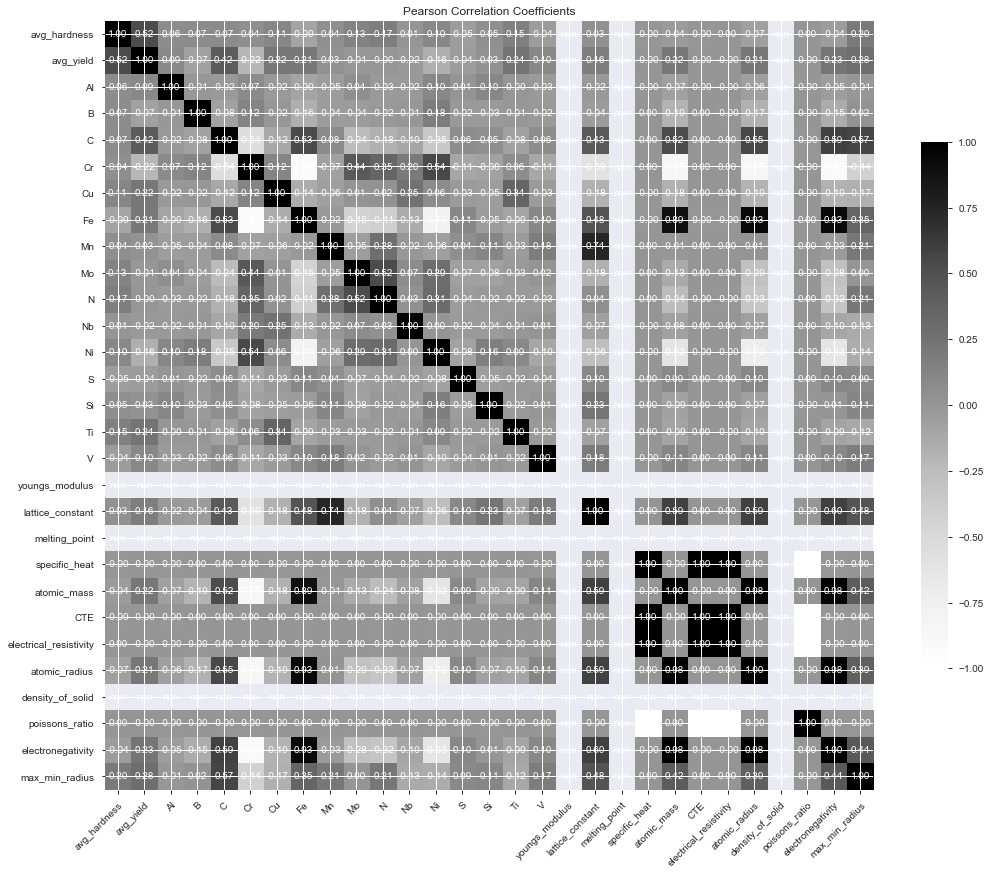

In [45]:
# Create the plot
fig, ax = plt.subplots(figsize = [15,15])
im = ax.imshow(p)

# We want to show all ticks...
ax.set_xticks(np.arange(len(data_labels)))
ax.set_yticks(np.arange(len(data_labels)))
# and label them with the respective list entries
ax.set_xticklabels(data_labels)
ax.set_yticklabels(data_labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for y in range(p.shape[0]):
    for x in range(p.shape[1]):
        plt.text(x, y, '%.2f' % p[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = "w",
                fontsize = 10)

ax.set_title("Pearson Correlation Coefficients")
cbar = plt.colorbar(im, shrink = 0.5)
fig.tight_layout()
plt.show()

## Creating the Neural Network

In [112]:
# Finally, I'm also going to drop the avg_yield column, since this IS what we want to predict
# I will also make a list of it to use later
all_labels = df['avg_yield'].tolist()
df = df.drop(['avg_yield'], axis=1)

# See what it looks like now
df.head()

,internal_id,avg_hardness,Al,B,C,Cr,Cu,Fe,Mn,Mo,...,melting_point,specific_heat,atomic_mass,CTE,electrical_resistivity,atomic_radius,density_of_solid,poissons_ratio,electronegativity,max_min_radius
70,MINFM7375,114.0,0.0,0.0,0.0,17.0,0.0,67.0499,0.0,0.0,...,1808.0,0.443,50.978826,0.000012,1.000000e-07,1.284699,7874.0,0.29,1.662013,0.05
72,MINFM7378,114.0,0.0,0.0,0.0,17.0,0.0,67.5899,0.0,0.0,...,1808.0,0.443,51.280389,0.000012,1.000000e-07,1.292259,7874.0,0.29,1.671895,0.05
73,MINFM50412,85.0,0.0,0.0,0.0,22.0,0.0,57.8449,0.0,0.0,...,1808.0,0.443,50.785834,0.000012,1.000000e-07,1.279829,7874.0,0.29,1.652962,0.05
77,MINFM7562,254.0,0.0,0.0,0.2,0.0,0.0,98.1749,0.7,0.2,...,1808.0,0.443,55.468369,0.000012,1.000000e-07,1.390199,7874.0,0.29,1.819721,0.75
80,MINFM7928,107.5,0.0,0.0,0.6,16.0,0.0,78.4299,0.0,0.0,...,1808.0,0.443,52.190618,0.000012,1.000000e-07,1.326219,7874.0,0.29,1.716167,0.70


Shape of Values: (626, 28)
Shape of Labels: (626,)
Sample entry from training set
[-0.71934222 -0.14137874 -0.10383794 -0.79863715  1.1796659  -0.16347399
 -1.23058631 -0.4300019  -0.39965122 -0.22409069 -0.13238994  1.07091566
 -0.1833592  -0.36935794 -0.10190336 -0.21812159         nan -1.30199315
         nan -1.         -1.57120691 -1.         -1.         -1.49242228
         nan -1.         -1.4801709  -1.38278659]
387.6421725239617
241.7652197489626


/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


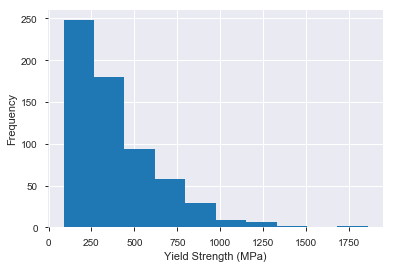

In [113]:
import random

# I get all the values as a numpy array here
all_values = df.iloc[:,1:].values
# This is just the internal ID's
id_values = df.iloc[:,0].values

# List of lists are turned into numpy arrays to facilitate calculations in steps to follow (Normalization).
all_values = np.array(all_values, dtype = float) 
print("Shape of Values:", all_values.shape)
all_labels = np.array(all_labels, dtype = float)
print("Shape of Labels:", all_labels.shape)

# Uncomment the line below to shuffle the dataset (we do not do this here to ensure consistent results for every run)
#order = list(range(0, len(df)))
#random.shuffle(order)         # This numpy argsort returns the indexes that would be used to shuffle a list
order = np.arange(len(df))
some_values = all_values[order]
some_labels = all_labels[order]
some_materials = (df.iloc[:,0].values)[order]
id_values = id_values[order]

# We'll use this for the splitting of our data in to training and testing
length = int(np.rint(0.10*len(df)))

# Training Set
train_labels = some_labels[:(len(df) - length)]
train_values = some_values[:(len(df) - length)]

# Testing Set
test_labels = some_labels[-length:]
test_values = some_values[-length:]

# NORMALIZATION

mean = np.mean(train_values, axis = 0) # mean
std = np.std(train_values, axis = 0) # standard deviation

train_values = (train_values - mean) / std # input scaling
test_values = (test_values - mean) / std # input scaling

# This line is used for labels in the plots
# Marked in red
labeled_materials = id_values[(len(df)-length):]
# Marked in blue
materials = id_values

#print(order)
print("Sample entry from training set")
print(train_values[0]) # print a sample entry from the training set

# Here is the average and standard devation of the hardness for reference (uncomment if you wish to see them)
yield_avg = np.mean(all_labels)
yield_std = np.std(all_labels)
print(yield_avg) 
print(yield_std)

# Uncomment if you want to see a distribution of the hardness values
plt.hist(all_labels)
plt.xlabel('Yield Strength (MPa)')
plt.ylabel('Frequency')
plt.show()

In [291]:
'''# Measures of Spread (don't run this every time...)
yield_avg = np.mean(all_labels)
yield_std = np.std(all_labels)
yield_median = np.median(all_labels)
yield_var = np.var(all_labels)
yield_max = np.max(all_labels)
yield_min = np.min(all_labels)
yield_range = yield_max - yield_min

hardness_avg = np.mean(df['avg_hardness'])
hardness_std = np.std(df['avg_hardness'])
hardness_median = np.median(df['avg_hardness'])
hardness_var = np.var(df['avg_hardness'])
hardness_max = np.max(df['avg_hardness'])
hardness_min = np.min(df['avg_hardness'])
hardness_range = hardness_max - hardness_min

spread_data = [[yield_avg, yield_std, yield_median, yield_var, yield_max, yield_min, yield_range],[hardness_avg, hardness_std, hardness_median, hardness_var, hardness_max, hardness_min, hardness_range]]
spread_df = pd.DataFrame(spread_data, columns = ['average', 'std_dev', 'median', 'variance', 'maximum', 'minimum', 'range'], index = ['yield_strength', 'hardness'])

# Save to a file
spread_df.to_csv('spread_df.csv')
'''

"# Measures of Spread (don't run this every time...)\nyield_avg = np.mean(all_labels)\nyield_std = np.std(all_labels)\nyield_median = np.median(all_labels)\nyield_var = np.var(all_labels)\nyield_max = np.max(all_labels)\nyield_min = np.min(all_labels)\nyield_range = yield_max - yield_min\n\nhardness_avg = np.mean(df['avg_hardness'])\nhardness_std = np.std(df['avg_hardness'])\nhardness_median = np.median(df['avg_hardness'])\nhardness_var = np.var(df['avg_hardness'])\nhardness_max = np.max(df['avg_hardness'])\nhardness_min = np.min(df['avg_hardness'])\nhardness_range = hardness_max - hardness_min\n\nspread_data = [[yield_avg, yield_std, yield_median, yield_var, yield_max, yield_min, yield_range],[hardness_avg, hardness_std, hardness_median, hardness_var, hardness_max, hardness_min, hardness_range]]\nspread_df = pd.DataFrame(spread_data, columns = ['average', 'std_dev', 'median', 'variance', 'maximum', 'minimum', 'range'], index = ['yield_strength', 'hardness'])\n\n# Save to a file\nsprea

In [48]:
# Training!  

# DEFINITION OF THE MODEL
from keras.layers import LeakyReLU
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal()

model = Sequential()
model.add(Dense(36, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init))
model.add(Dense(22, activation='relu', kernel_initializer=kernel_init))
model.add(Dense(1, activation='relu', kernel_initializer=kernel_init))

# DEFINITION OF THE OPTIMIZER

optimizer = tf.train.RMSPropOptimizer(0.002) # Root Mean Squared Propagation

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
# model.summary() # Comment this out if you don't want to see the model summary

class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + '\r') # Updates current Epoch Number

mae_es= keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=1000, verbose=1, mode='auto', restore_best_weights=True)    
EPOCHS = 10000 # Number of EPOCHS

# HISTORY Object which contains how the model learned
# Training Values (Properties), Training Labels 
history = model.fit(train_values, train_labels, 
                        epochs = EPOCHS, verbose = False, shuffle = True, batch_size = len(df), validation_split = 0.10, callbacks=[mae_es, PrintEpNum()]) 


[loss_train, mae_train] = model.evaluate(train_values, train_labels, verbose=0)
[loss_test, mae_test] = model.evaluate(test_values, test_labels, verbose=0)


plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),label = 'Validation loss')
plt.legend()
plt.show()

# Display the same information being written to the file
print(" ".join(str(x) for x in [mae_train, mae_test]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Restoring model weights from the end of the best epoch.


TypeError: 'NoneType' object is not subscriptable

In [293]:
# PLOTTING

test_predictions = model.predict(test_values).flatten()
'''
print("Materials in Test Set: ", labeled_materials)
print("Real Values", list(test_labels))
print("Predictions", list(test_predictions))
'''
values = np.concatenate((train_values, test_values), axis=0) # This line joins the values together to evaluate all of them
predictions = model.predict(values).flatten()

In [294]:
# PLOTTING
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot

plotly.offline.init_notebook_mode(connected=True)

layout0= go.Layout(title= "Yield Strength", hovermode= 'closest',
    xaxis= dict(title= 'Real Values',zeroline= False, gridwidth= 2),
    yaxis= dict(title= 'Predictions',zeroline= False, gridwidth= 2),
    showlegend= False                 
)

trace0 = go.Scatter(x = all_labels, y = predictions, mode = 'markers', marker= dict(size= 12, color= 'blue'), text = id_values)
trace1 = go.Scatter(x = test_labels, y = test_predictions, mode = 'markers', marker= dict(size= 12, color= 'red'), text = labeled_materials)
trace2 = go.Scatter(x = [0,1500], y = [0,1500], mode = 'lines', name = "Match") # This trace is the line X = Y which would indicate that the Prediction equals the real value

data = [trace0, trace1, trace2]
fig= go.Figure(data, layout=layout0)
iplot(fig)